# Kalman Filter & Pair Trading Strategy Case Study

### (1) Read Data and Data Preparation

In [11]:
import numpy as np
import pandas as pd
from pykalman import KalmanFilter

data_spy = pd.read_csv('SPY.csv')
data_dia = pd.read_csv('DIA.csv')

data_spy = data_spy.drop(columns=['Open','High','Low','Adj Close','Volume'])
data_dia = data_dia.drop(columns=['Open','High','Low','Adj Close','Volume'])

data_spy = data_spy.rename(columns = {"Close":"SPY Close"})
data_dia = data_dia.rename(columns = {"Close":"DIA Close"})

df = data_spy.merge(data_dia)

df.set_index('Date',inplace=True)

length = len(df["SPY Close"])
spy_return = np.zeros(length)
dia_return = np.zeros(length)
for i in reversed(range(1,length)):
    spy_return[i] = df["SPY Close"][i]/df["SPY Close"][i-1] - 1
    dia_return[i] = df["DIA Close"][i]/df["DIA Close"][i-1] - 1
    
df["SPY Return"] = spy_return
df["DIA Return"] = dia_return

df.tail()

,SPY Close,DIA Close,SPY Return,DIA Return
Date,,,,
2020-02-11,335.260010,292.940002,0.001733,-0.000034
2020-02-12,337.420013,295.720001,0.006443,0.009490
2020-02-13,337.059998,294.820007,-0.001067,-0.003043
2020-02-14,337.600006,294.540009,0.001602,-0.000950
2020-02-18,336.730011,292.950012,-0.002577,-0.005398


### (2) Apply Kalman Filter to Update Beta Throughout the Time

In [12]:
state_means = 1
state_covs = 0.01
beta = np.zeros(length)
vt = np.zeros(length)
beta[0] = state_means

for i in range(length):
    kf = KalmanFilter(n_dim_obs=1, n_dim_state=1,
                      initial_state_mean=state_means,
                      initial_state_covariance=state_covs,
                      transition_matrices=1,
                      observation_matrices=df.iloc[i,1],
                      observation_covariance=1,
                      transition_covariance=1)
    state_means = float(kf.filter_update(state_means,state_covs,df.iloc[i,0])[0])
    state_covs = float(kf.filter_update(state_means,state_covs,df.iloc[i,0])[1])
    beta[i] = state_means
    vt[i] = df.iloc[i,0]-beta[i]*df.iloc[i,1]

df["Updated Beta from Kalman Filter"] = beta
df["Residual Vt from Kalman Filter"] = vt

df.tail()

,SPY Close,DIA Close,SPY Return,DIA Return,Updated Beta from Kalman Filter,Residual Vt from Kalman Filter
Date,,,,,,
2020-02-11,335.260010,292.940002,0.001733,-0.000034,1.144466,0.000007
2020-02-12,337.420013,295.720001,0.006443,0.009490,1.141012,-0.000012
2020-02-13,337.059998,294.820007,-0.001067,-0.003043,1.143274,0.000008
2020-02-14,337.600006,294.540009,0.001602,-0.000950,1.146194,0.000010
2020-02-18,336.730011,292.950012,-0.002577,-0.005398,1.149445,0.000011


### (3) Use Updated Beta to Implement Pair Trading Strategy

In [13]:
kf_return = np.ones(length)
k = 0.5

for i in range(126,length):
    vt_temp = vt[0:i]
    vt_std = vt_temp.std()
    if df.iloc[i-1,5] >= k*vt_std:
        kf_return[i] = kf_return[i-1]*(1+((beta[i-1]*df.iloc[i-1,1]/(beta[i-1]*df.iloc[i-1,1]+df.iloc[i-1,0]))*dia_return[i]+(df.iloc[i-1,0]/(beta[i-1]*df.iloc[i-1,1]+df.iloc[i-1,0]))*(-spy_return[i])))
    elif df.iloc[i-1,5] <= -k*vt_std:
        kf_return[i] = kf_return[i-1]*(1+((beta[i-1]*df.iloc[i-1,1]/(beta[i-1]*df.iloc[i-1,1]+df.iloc[i-1,0]))*(-dia_return[i])+(df.iloc[i-1,0]/(beta[i-1]*df.iloc[i-1,1]+df.iloc[i-1,0]))*spy_return[i]))
    else:
        kf_return[i] = kf_return[i-1]
        
df["Cumulative Return from Kalman Filter"] = kf_return

df.tail()

,SPY Close,DIA Close,SPY Return,DIA Return,Updated Beta from Kalman Filter,Residual Vt from Kalman Filter,Cumulative Return from Kalman Filter
Date,,,,,,,
2020-02-11,335.260010,292.940002,0.001733,-0.000034,1.144466,0.000007,1.090454
2020-02-12,337.420013,295.720001,0.006443,0.009490,1.141012,-0.000012,1.090454
2020-02-13,337.059998,294.820007,-0.001067,-0.003043,1.143274,0.000008,1.090454
2020-02-14,337.600006,294.540009,0.001602,-0.000950,1.146194,0.000010,1.090454
2020-02-18,336.730011,292.950012,-0.002577,-0.005398,1.149445,0.000011,1.090454


### (4) Update Beta from 6-Month Rolling Regression

In [14]:
from sklearn.linear_model import LinearRegression

beta_ols = np.ones(length)
vt_ols = np.zeros(length)
for i in range(125,length):
    X_train = df.iloc[i-125:i+1,1].to_numpy().reshape((-1,1))
    y_train = df.iloc[i-125:i+1,0].to_numpy().reshape((-1,1))
    regr = LinearRegression(fit_intercept=False).fit(X_train, y_train)
    beta_ols[i] = regr.coef_
    vt_ols[i] = df.iloc[i,0]-beta_ols[i]*df.iloc[i,1]

df["Updated Beta from OLS"] = beta_ols
df["Residual Vt from OLS"] = vt_ols

df.tail()

,SPY Close,DIA Close,SPY Return,DIA Return,Updated Beta from Kalman Filter,Residual Vt from Kalman Filter,Cumulative Return from Kalman Filter,Updated Beta from OLS,Residual Vt from OLS
Date,,,,,,,,,
2020-02-11,335.260010,292.940002,0.001733,-0.000034,1.144466,0.000007,1.090454,1.119746,7.241482
2020-02-12,337.420013,295.720001,0.006443,0.009490,1.141012,-0.000012,1.090454,1.119998,6.214158
2020-02-13,337.059998,294.820007,-0.001067,-0.003043,1.143274,0.000008,1.090454,1.120255,6.786314
2020-02-14,337.600006,294.540009,0.001602,-0.000950,1.146194,0.000010,1.090454,1.120556,7.551555
2020-02-18,336.730011,292.950012,-0.002577,-0.005398,1.149445,0.000011,1.090454,1.120845,8.378505


### (5) Use Beta from Rolling Regression to Implement Pair Trading Strategy

In [15]:
ols_return = np.ones(length)
k = 0.5

for i in range(126,length):
    olsvt_temp = vt_ols[126:i]
    olsvt_std = olsvt_temp.std()
    if df.iloc[i-1,8] >= k*olsvt_std:
        ols_return[i] = ols_return[i-1]*(1+((beta_ols[i-1]*df.iloc[i-1,1]/(beta_ols[i-1]*df.iloc[i-1,1]+df.iloc[i-1,0]))*dia_return[i]+(df.iloc[i-1,0]/(beta_ols[i-1]*df.iloc[i-1,1]+df.iloc[i-1,0]))*(-spy_return[i])))
    elif df.iloc[i-1,8] <= -k*olsvt_std:
        ols_return[i] = ols_return[i-1]*(1+((beta_ols[i-1]*df.iloc[i-1,1]/(beta_ols[i-1]*df.iloc[i-1,1]+df.iloc[i-1,0]))*(-dia_return[i])+(df.iloc[i-1,0]/(beta_ols[i-1]*df.iloc[i-1,1]+df.iloc[i-1,0]))*spy_return[i]))
    else:
        ols_return[i] = ols_return[i-1]
        
df["Cumulative Return from OLS"] = ols_return

df.tail()

/Users/zheyugu/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/zheyugu/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/zheyugu/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


,SPY Close,DIA Close,SPY Return,DIA Return,Updated Beta from Kalman Filter,Residual Vt from Kalman Filter,Cumulative Return from Kalman Filter,Updated Beta from OLS,Residual Vt from OLS,Cumulative Return from OLS
Date,,,,,,,,,,
2020-02-11,335.260010,292.940002,0.001733,-0.000034,1.144466,0.000007,1.090454,1.119746,7.241482,0.979988
2020-02-12,337.420013,295.720001,0.006443,0.009490,1.141012,-0.000012,1.090454,1.119998,6.214158,0.981396
2020-02-13,337.059998,294.820007,-0.001067,-0.003043,1.143274,0.000008,1.090454,1.120255,6.786314,0.980445
2020-02-14,337.600006,294.540009,0.001602,-0.000950,1.146194,0.000010,1.090454,1.120556,7.551555,0.979191
2020-02-18,336.730011,292.950012,-0.002577,-0.005398,1.149445,0.000011,1.090454,1.120845,8.378505,0.977854


### (6) Comparison Between Two Models

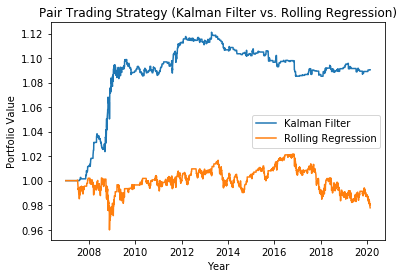

In [16]:
import matplotlib.pyplot as plt

df.index = pd.to_datetime(df.index)
date = list(df.index)
plt.plot(date,kf_return,label="Kalman Filter")
plt.plot(date,ols_return,label="Rolling Regression")
plt.xlabel('Year')
plt.ylabel('Portfolio Value')
plt.title('Pair Trading Strategy (Kalman Filter vs. Rolling Regression)')
plt.legend()
plt.show()

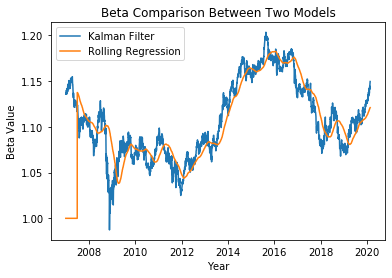

In [17]:
import matplotlib.pyplot as plt

plt.plot(date,beta,label="Kalman Filter")
plt.plot(date,beta_ols,label="Rolling Regression")
plt.xlabel('Year')
plt.ylabel('Beta Value')
plt.title('Beta Comparison Between Two Models')
plt.legend()
plt.show()

**Conclusion:** As we can see from the first graph, the beta update equation from Kalman Filter gives us more accurate approximations to the real beta. Therefore, the pair trading strategy of SPY and DIA derived from Kalman Filter beta update equation significantly outperforms the one derived from 6-month rolling regression. Kalman Filter's accuracy comes from its ability to put more weights on the most recent observations and the ability to get feedback from its prediction errors, which then later will be used to adjust the state. Due to the dynamic features of Kalman Filter, the pattern from the second graph can be easily interpreted, where Kalman Filter beta is more reactive than the rolling regression beta throughout the time. *(Note: Both returns and rolling regression beta are set to be 1 for the first 126 trading days, when rolling regression model is being trained)*